In [1]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
h = 0.000001
x = 3
(f(x+h)-f(x))/h

14.000003002223593

In [4]:
class Value:
    def __init__(self,data,op='',children=(),label=''):
        self.data = data
        self.grad = 0
        self._op = op
        self._backward = lambda : None
        self._prev = children
        self.label = label
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self,other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data+other.data,children=(self,other), op='+')
        def backward():
            self.grad += out.grad
            other.grad += out.grad 
        out._backward = backward
        return out
   
    def __mul__(self,other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data*other.data,children=(self,other),op='*')
        def backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        
        out = Value(self.data**other,op=f'**{other}',children=(self,))
        def backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = backward
        return out
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    
    def exp(self):
        out = Value(math.exp(self.data),children=(self,),op='exp')
        def backward():
            self.grad = out.data * out.grad
        out._backward = backward
        
        return out
    
    def tanh(self):
        x = self.data
        res = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(res,op='tanh',children=(self,))
        def backward():
            self.grad += (1 - res**2) * out.grad
        out._backward = backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1 
        for node in reversed(topo):
            node._backward()
                    
    

In [5]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n)) 
        # for any value in the graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
        if n._op: #if this value is a result of some operation, create op node for it
            dot.node(name=uid +n._op, label = n._op) # and connect this node to it
            dot.edge(uid+n._op, uid)
                 
    for n1, n2 in edges:
        # connect nl to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [6]:
x1 = Value(2,label='x1')
x2 = Value(0,label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.88,label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2+b; n.label='n'

e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label='o'
o.backward()

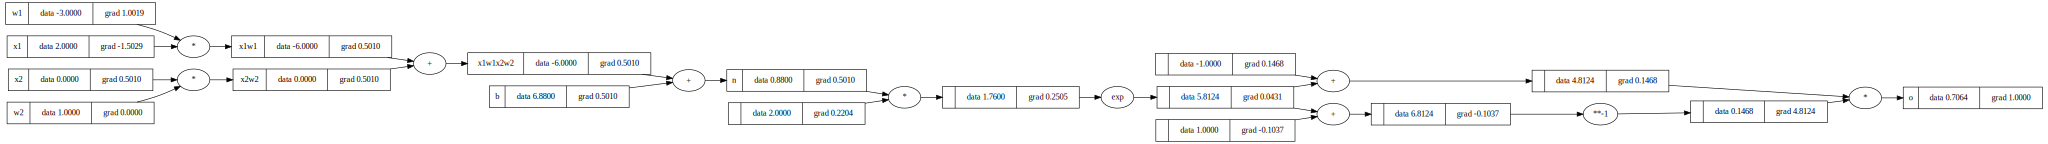

In [7]:
draw_dot(o)

In [8]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
    
    def parameters(self):
        return self.w + [self.b]
    
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def parameters(self):
        return [param for n in self.neurons for param in n.parameters()]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters() ]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
            
        return x

In [9]:
n = MLP(3,[4,4,1])

In [10]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1,-1,-1,1]

In [17]:
for k in range(10):
    preds = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,preds))
    
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k,' ',loss.data)

0   0.00039446915688028333
1   0.00039377577228032196
2   0.00039308477097743286
3   0.0003923961408022506
4   0.0003917098696677535
5   0.00039102594556858386
6   0.00039034435658037486
7   0.00038966509085902736
8   0.0003889881366400679
9   0.000388313482238005
